### Урок3. Связь бизнес-показателей и DS-метрик

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [1]:
import numpy as np
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import  roc_curve, roc_auc_score, log_loss, precision_recall_curve, confusion_matrix

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


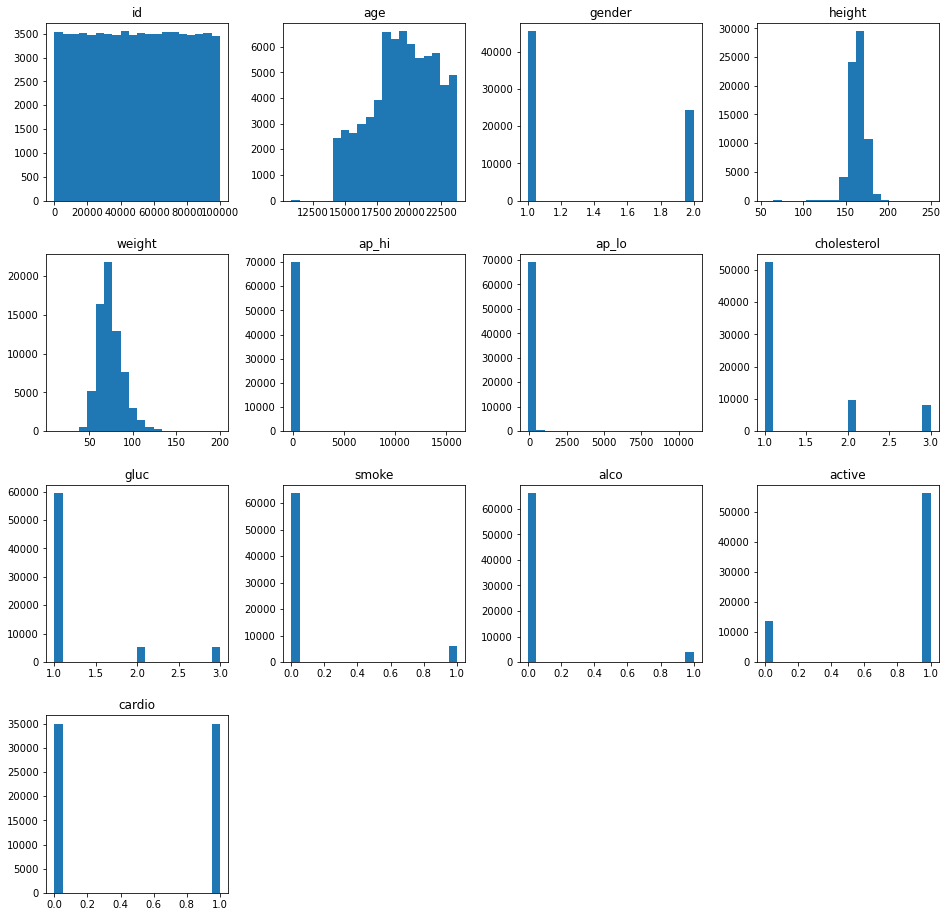

In [4]:
_ = df.hist(figsize=(16,16), bins=20, grid=False)

Следует обработать признаки ap_lo и ap_hi на выбросы

### Проверка сбалансированности классов

In [5]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

Классы неплохо сбалансированы

In [6]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

class APtransform(BaseEstimator, TransformerMixin):
    def __init__(self, key, min, max):
        self.key = key
        self.min = min
        self.max = max

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.key] = X[self.key].apply(lambda x: np.clip(np.absolute(x), self.min, self.max))
        return X[[self.key]]

In [8]:
def get_best_model(feats, X, y):

    models = {
        0: {'name': 'LogisticRegression', 'estimator': LogisticRegression()},
        1: {'name': 'RidgeClassifier', 'estimator': RidgeClassifier()},
        2: {'name': 'SGDClassifier', 'estimator': SGDClassifier()},
        3: {'name': 'LinearSVC', 'estimator': LinearSVC()},
        4: {'name': 'DecisionTreeClassifier', 'estimator': DecisionTreeClassifier()},
        5: {'name': 'ExtraTreeClassifier', 'estimator': ExtraTreeClassifier()},
        6: {'name': 'GradientBoostingClassifier', 'estimator': GradientBoostingClassifier()},
    }

    results = dict()
    for k in models.keys():
        classifier = Pipeline([
            ('features',feats),
            ('classifier', models[k]['estimator']),
        ])
        score = cross_validate(
            classifier,
            X,
            y,
            cv=15,
            scoring=('roc_auc', 'f1', 'precision', 'recall'),
        )
        
        key = models[k]['name']
        results[key] = {
            'roc_auc': np.mean(score['test_roc_auc']),
            'f1': np.mean(score['test_f1']),
            'precision': np.mean(score['test_precision']),
            'recall': np.mean(score['test_recall']),
        }
    
    return results

In [9]:
target = 'cardio'

X = df.drop(target, 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42
)

## Формирование пайплайна

In [10]:
continuos_transformers = []
cat_transformers = []
base_transformers = []

continuos_cols = ['age', 'height', 'weight']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

# обработка выбросов ap_hi
ap_hi_transformer = Pipeline([
    ('selector', NumberSelector(key='ap_hi')),
    ('ap_hi', APtransform(key='ap_hi', min=100, max=230)),
    ('standard', StandardScaler())
])
base_transformers.append(('ap_hi', ap_hi_transformer))

# обработка выбросов ap_lo
ap_lo_transformer = Pipeline([
    ('selector', NumberSelector(key='ap_lo')),
    ('ap_lo', APtransform(key='ap_lo', min=60, max=130)),
    ('standard', StandardScaler())
])
base_transformers.append(('ap_lo', ap_lo_transformer))

for cont_col in continuos_cols:
    transfomer =  Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
    ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
        ('selector', ColumnSelector(key=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
        ('selector', NumberSelector(key=base_col))
    ])
    base_transformers.append((base_col, base_transformer))

feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)

## Сравнение моделей

In [11]:
results = get_best_model(feats, X_train, y_train)
pd.DataFrame.from_dict(results, orient='index').sort_values(by='roc_auc', ascending=False)

,roc_auc,f1,precision,recall
GradientBoostingClassifier,0.802317,0.724485,0.752117,0.698974
LogisticRegression,0.791772,0.709822,0.756588,0.668669
LinearSVC,0.791613,0.705898,0.760304,0.658923
RidgeClassifier,0.791137,0.704016,0.761357,0.654873
SGDClassifier,0.788021,0.701766,0.758428,0.656522
ExtraTreeClassifier,0.638036,0.637167,0.636780,0.637712
DecisionTreeClassifier,0.631382,0.629753,0.630735,0.628846


## Обучение модели

In [12]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(
    classifier,
    X_train,
    y_train,
    cv=15,
    scoring='roc_auc'
)
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8023162928936851+-0.009395659912736628


## Поиск оптимальной b

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)

b_list = np.arange(0.1, 2, 0.1)
for b in b_list:

    fscore = (1 + b**2) * (precision * recall) / (b**2*precision + recall)

    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'b=%.1f Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % 
        (b, thresholds[ix], fscore[ix], precision[ix], recall[ix]))

b=0.1 Best Threshold=0.835652, F-Score=0.851, Precision=0.868, Recall=0.281
b=0.2 Best Threshold=0.729030, F-Score=0.816, Precision=0.835, Recall=0.515
b=0.3 Best Threshold=0.695089, F-Score=0.795, Precision=0.832, Recall=0.533
b=0.4 Best Threshold=0.607309, F-Score=0.777, Precision=0.819, Recall=0.586
b=0.5 Best Threshold=0.570356, F-Score=0.759, Precision=0.804, Recall=0.620
b=0.6 Best Threshold=0.536058, F-Score=0.749, Precision=0.784, Recall=0.665
b=0.7 Best Threshold=0.525332, F-Score=0.741, Precision=0.775, Recall=0.680
b=0.8 Best Threshold=0.418264, F-Score=0.739, Precision=0.722, Recall=0.767
b=0.9 Best Threshold=0.391061, F-Score=0.742, Precision=0.704, Recall=0.796
b=1.0 Best Threshold=0.391061, F-Score=0.747, Precision=0.704, Recall=0.796
b=1.1 Best Threshold=0.355037, F-Score=0.753, Precision=0.671, Recall=0.837
b=1.2 Best Threshold=0.335353, F-Score=0.761, Precision=0.658, Recall=0.853
b=1.3 Best Threshold=0.283510, F-Score=0.771, Precision=0.620, Recall=0.901
b=1.4 Best T

In [14]:
b = 0.8
fscore = (1 + b**2) * (precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)

print(f'b=%.1f Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % 
        (b, thresholds[ix], fscore[ix], precision[ix], recall[ix]))

b=0.8 Best Threshold=0.418264, F-Score=0.739, Precision=0.722, Recall=0.767


## Roc curve

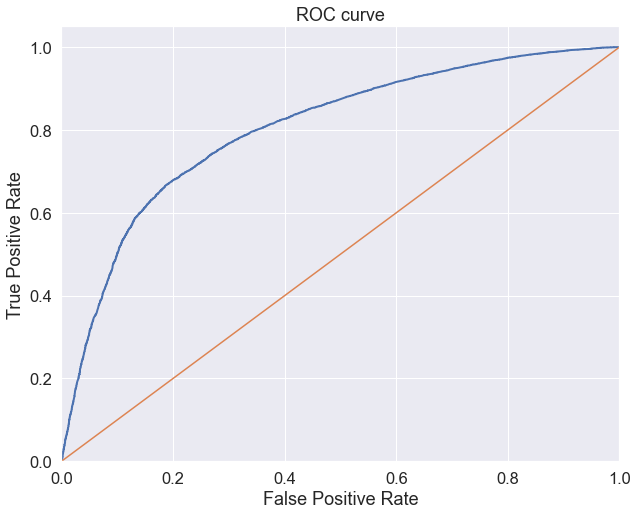

In [15]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [16]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.8034309536468351
log loss score: 0.5390407868413115


## Матрица ошибок

Confusion matrix, without normalization
[[6086 2602]
 [2050 6762]]


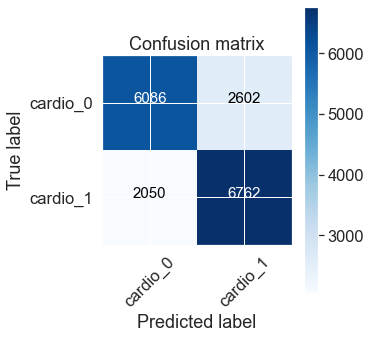

In [17]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(5, 5))
plot_confusion_matrix(
    cnf_matrix,
    classes=['cardio_0', 'cardio_1'],
    title='Confusion matrix'
)
plt.savefig("conf_matrix.png")
plt.show()

## Подсчет TPR, FPR, TNR

In [18]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.7673626872446664, 0.2994935543278085, 0.7005064456721916)

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Обучены следующие модели:

* GradientBoostingClassifier
* LogisticRegression
* LinearSVC
* RidgeClassifier
* SGDClassifier
* ExtraTreeClassifier
* DecisionTreeClassifier

Лучший результат показала модель GradientBoostingClassifier:

* roc auc 0.802312
* f1 0.724485
* precision 0.752117
* recall 0.698974

(опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

* При перекосе по классу 0 надо использовать precision_recall_curve
* Когда примерно поровну или перекос по классу 1, тогда roc_auc_curve